# Objectives
- Describe a driving path using a belzier
    - I need to be able to randomly generate belzier curves
    - I can use the nature of belzier curves being envelopes of non-discrete lines to my advantedge. 
    - Instead of getting the envelope, I can work backwards to just take the distance formula at each point
- Interpolate the equation of that belzier
- Export the interpolated lines into a graph
<img src="belzier_formula.jpg" />

In [679]:
import scipy.special
import random
scipy.special.binom(4, 2)
# Make a list with length n, with random points in the range [0,10]
import numpy as np
size = random.randint(1, 10)
pointList = np.random.rand(size,2)*10
# t goes up to 1
interp = .01
def belzierPoint(pointList,t):
    x_i = 0
    y_i = 0
    n = len(pointList)
    # So then loop through the interpolate t from 0 to 1 by .1
    for i, point in enumerate(pointList):
        x_i += scipy.special.binom(n,i)*((1-t)**(n-i))*t**i*point[0]
        y_i += scipy.special.binom(n,i)*((1-t)**(n-i))*t**i*point[1]
    return x_i,y_i

def belzier(pointList, t = None):
    x,y = [],[]
    if t == None:
        for t in np.arange(0, 1+interp, interp):
            x_i,y_i = belzierPoint(pointList,t)
            x.append(x_i)
            y.append(y_i)
    return x,y
x,y = belzier(pointList)



In [680]:
linePoints =[]
lines = []
numLines = 7
lineInterp = 1/numLines
for i in np.arange(0, 1+lineInterp, lineInterp):
    x_i,y_i = belzierPoint(pointList,i)
    linePoints.append([x_i,y_i])
for i in range(len(linePoints)):
    if(i!=0):
        lines.append([linePoints[i-1],linePoints[i]])

        


## Similar Slope Merging

In [681]:
for i in range(len(lines)):
    if(i!=0 and i<len(lines)-1):
        slope1 = (lines[i-1][0][1]-lines[i-1][1][1])/(lines[i-1][0][0]-lines[i-1][1][0])
        slope2 = (lines[i][0][1]-lines[i][1][1])/(lines[i][0][0]-lines[i][1][0])
        percent_diff=abs(slope1-slope2)/((slope1+slope2)/2)
        if(abs(percent_diff)<0.2):
            lines[i-1]=[lines[i-1][0],lines[i][1]]
            lines.pop(i)
            linePoints.pop(i)


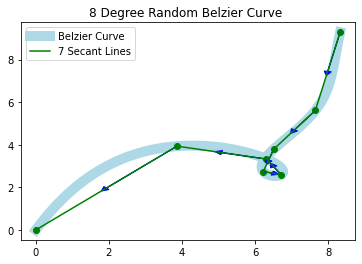

In [682]:
from matplotlib.widgets import Slider, Button, RadioButtons
plt.plot(x,y,label='Belzier Curve',linewidth=10,color= 'lightblue',zorder=1)

plt.title(str(size)+' Degree Random Belzier Curve ') 
x_p,y_p = pointList.T
# plt.scatter(x_p,y_p,color = 'r',label = 'Control Points')
x_l,y_l = zip(*linePoints)
ax = plt.gca()
plt.scatter(x_l,y_l,color = 'g',zorder=2)
plt.plot(x_l,y_l,color = 'g',label = str(len(lines))+' Secant Lines',zorder=2)

for i in range(len(linePoints)):
    if i<len(linePoints)-1:
        plt.arrow(x_l[i],y_l[i],(x_l[i+1]-x_l[i])/2,(y_l[i+1]-y_l[i])/2,head_width=0.2,head_length=0.2,color='blue',zorder=2)

plt.legend()

In [698]:
import math
for i in range(len(lines)):
    x_dist = lines[i][0][0]-lines[i][1][0]
    y_dist = lines[i][0][1]-lines[i][1][1]
    distance = math.sqrt(x_dist**2+y_dist**2)
    # if i!=0:
    #     angle = angle -math.atan2(y_dist,x_dist)
    # else:
    angle = math.atan2(y_dist,x_dist)
    print(distance,angle)

3.7356072315369437 1.387821261334017
2.1399075330506396 1.0105515896309543
1.0918737481127694 1.3037148870319375
0.5126647708619528 2.848940187839512
0.8356539148490012 -1.069557230183374
2.5231168958975174 -0.24301795249789265
5.514367134239435 0.7940123388925978
